# "Standard Candle" Toy 6: Bring in Auxiliary Channel

Convert the first channel to an image with no brightness changes, to simulate having an auxiliary channel. Also, change how we are producing our global mean and standard deviation. Finally, normalize and center our images _then_ apply brightness changes when things are actually fetched.

Note that this notebook should be run from the `notebooks/` subdirectory.

## Setup

In [118]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '06b_simple_toy1'

from collections import namedtuple, defaultdict
import math
import random
import os
import shutil
import pdb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import pandas

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

In [119]:
# Protective code to ensure we always reset the random seed when doing training, or else
# code won't be reproducible.
if 'training_runs_count' not in globals():
  training_runs_count = 0
if 'seed_reset_count' not in globals():
  seed_reset_count = 0

# Path to data and training results.
root_path = '../..' # Relative to: notebooks/01b_simple_toy
data_path = os.path.join(root_path, 'data', notebook_name)
results_path = os.path.join(root_path, 'training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

for path in [data_path, results_path]:
  if not os.path.exists(path):
    print('{} does not exist; creating directory...'.format(os.path.abspath(path)))
    os.makedirs(path)

n_epochs = 8
# TODO: Since we have a larger GPU with more memory, explore a larger batch size for
# training; this might speed up training but have an adverse effect on accuracy. Explore.
batch_size_train = 64
batch_size_test = 1000
log_interval = 50

height = 28
width = 28
max_pixel_value = 255.0

# Number of MNIST images given to the network at once.
# NOTE: If the auxiliary channel is turned on, then the first channel will be an image
# with its original correct brightness.
num_channels = 7

In [120]:
# Use the GPU.
cuda_device = 1
torch.backends.cudnn.enabled = True
if not torch.cuda.is_available():
  raise RuntimeError("CUDA not available! Unable to continue")
# Force ourselves to use only one GPU.
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
  device, torch.cuda.current_device(), torch.cuda.device_count()))

# Force runs to be deterministic and reproducible.
random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# TODO: What kind of performance hit are are we seeing due to forcing CUDNN to
# be deterministic?
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(random_seed)
seed_reset_count += 1

Using device cuda:1 for training, current device: 0, total devices: 6


In [121]:
"""
Custom pytorch dataset that returns multi-channel MNIST results all of the same class (0 through 9) but
with different hand-drawn images as each channel. Also applies a random brightness factor to each image.
"""
class MultiChannelBrightnessMNIST(torchvision.datasets.MNIST):
  
  SampleTuple = namedtuple("Sample", "image mnist_class target_brightness")
  
  # TODO: Use dynamic arguments to super() to not have to hard code these params
  # from torchvision.datsets.MNIST.
  def __init__(self, root, aux_channel=True, apply_brightness=True,
               train=True, transform=None,
               target_transform=None, download=False):
    super(MultiChannelBrightnessMNIST, self).__init__(
      root, train, transform, target_transform, download)
    
    self._data_name = "train" if train else "test"
    self._aux_channel = aux_channel
    self._apply_brightness = apply_brightness
    self._debug_images_printed = False
    
    self._setup_samples()
    self._compute_statistics()

  def _setup_samples(self):
    """
    Re-organizes the data into tuples of the following form to make them easier to work with,
    as well as to record what the random brightness is for correctly generating statistics
    and ground truth information:

    (image, mnist_class, target_brightness)

    Also creates a hashtable that goes from the target class to all available image tuples
    with those classes so we can quickly fetch images of the same class together.
    
    Note: internally in our lookup tables we store everything as either a scalar integer
    or a numpy array for the image. We do not store them as Torch tensors. The images
    themselves are stored internally as float32's rather than uint8.
    """
    self._available_samples = defaultdict(lambda: [])
    self._all_images = []
    for (image, mnist_class) in zip(self.data, self.targets):
      assert isinstance(image, torch.Tensor), \
        "self.data should have images as torch.Tensors"
      assert isinstance(mnist_class, torch.Tensor), \
        "self.data should have mnist_class targets as torch.Tensors"
      
      # Internally work with everything as scalars for the target, or as numpy
      # float32's to ensure no conversion errors between Torch/Numpy/PIL.Image
      # or incorrect force quantitization when going from uint8 to float32s.
      mnist_class = mnist_class.item()
      image = image.data.numpy()
      assert image.dtype == np.uint8, "image should initially be uint8"
      image = image.astype(np.float32)      
      
      target_brightness = self._compute_brightness()

      # Our loss function currently assumes that all brightness values are in the
      # range [0.0, 1.0]. If this assumption is broken make sure we know so that
      # in the future we can do extra work to 'squash' brightness values back
      # down to [0.0, 1.0]
      assert target_brightness >= 0.0 and target_brightness <= 1.0, \
        "Brightness must be in the range [0.0, 1.0] for the loss function to work"
      
      assert isinstance(mnist_class, int), \
        "Converted mnist class must ultimately be a scalar Python integer"
      assert isinstance(target_brightness, float), \
        "Converted target brightness must ultimately be a scalar Python float"
      assert image.dtype == np.float32, \
        "At end of _setup_samples() images should be uniformly float32 types"
      
      sample = self.SampleTuple(image=image,
                                mnist_class=mnist_class,
                                target_brightness=target_brightness)

      self._available_samples[mnist_class].append(sample)
      self._all_images.append(image)
    
    self._all_images = np.array(self._all_images, dtype=np.float32)
    
  def _compute_brightness(self):
    if self._apply_brightness:
      # Randomly compute what the brightness setting should be for each sample.
      # NOTE: Below 30% brightness accuracy degrades vs. the experiment 2 baseline.
      return np.round((0.3 - 1.0) * np.random.random_sample() + 1.0, decimals=2)
    else:
      return 1.0

  def _darken_image(self, brightness, img):
    return brightness * img
  
  def _compute_statistics(self):
    """
    Compute global mean and standard deviation for data input normalization.
    """
    self.global_mean = np.round(self._all_images.mean() / max_pixel_value, decimals=4)
    self.global_std = np.round(self._all_images.std() / max_pixel_value, decimals=4)
    
    # Ensure our computed mean and std are within what we've seen historically;
    # otherwise flag this as a potential bug.
    assert self.global_mean >= 0.05 and self.global_mean <= 0.2, \
      "Computed global mean is outside historical ranges seen: {}".format(
        self.global_mean)
    assert self.global_std >= 0.1 and self.global_std <= 0.4, \
      "Computed global std is outside historical ranges seen: {}".format(
        self.global_std)
      
  def __getitem__(self, index):
    # NOTE: We return items in bunches of num_channels. We also essentially
    # ignore the index and just return random bunches of the same class.

    # Randomly choose a class label.
    mnist_class = np.random.randint(low=0, high=10)
    assert isinstance(mnist_class, int), \
      "For __getitem__ mnist_class must be a Python int"
    samples_with_class = self._available_samples[mnist_class]

    # Fetch num_channel samples that have this target class.
    result_idxs = np.random.choice(len(samples_with_class), size=(num_channels,),
                                   replace=False)
    results = [samples_with_class[idx] for idx in result_idxs]

    for sample in results:
      assert type(sample.image).__module__ == np.__name__, \
        '__getitem__ should be dealing with numpy images as input!'
      assert sample.mnist_class == mnist_class, \
        'All items returned from __getitem__ should have the same MNIST class'

    # Turn the images into a single multi-channel image.
    multi_channel_img = torch.Tensor(np.zeros((num_channels, height, width),
                                              dtype=np.float32))
    for idx, sample in enumerate(results):
      single_channel_img = sample.image

      if self.transform is not None:
        single_channel_img = self.transform(single_channel_img)

      # If we want an aux channel, treat the first channel as the original
      # non-brightness diminished aux channel.
      if self._aux_channel and idx != 0:
        # Apply the brightness transform _after_ centering and normalizing
        # the image via the self.transform above.
        single_channel_img = self._darken_image(sample.target_brightness,
                                                single_channel_img)
    
      multi_channel_img[idx] = single_channel_img

    assert multi_channel_img.shape == (num_channels, height, width), \
      "multi_channel_img must have the correct shape"

    for sample in results:
      assert isinstance(sample.target_brightness, float), \
        "__getitem__ should be dealing with a scalar Python type for the target brightness!"

    # TODO: We aren't yet actually correctly implementing self.target_transform since we
    # don't need it currently.
    assert self.target_transform is None, "self.target_transform is not yet implemented"
    assert isinstance(sample.target_brightness, float), \
      "sample.target_brightness must be a Python float"
    target_brightness = torch.tensor(np.array([sample.target_brightness for sample in results],
                                              dtype=np.float32))
    # If we want an aux channel, treat the first channel as the original
    # non-brightness diminished aux channel.
    if self._aux_channel:
      assert num_channels > 1, 'If only one channel auxiliary channel makes no sense!'
      target_brightness[0] = 1.0
    
    debug_results = results

    # Print out some debug images just once to prevent too much clutter.
    if not self._debug_images_printed:
      print("\n\n\nDebug images from the same fetch for {} dataset; "
            "make sure all are same number and are legible:".format(self._data_name))
      for c in range(num_channels):
        display(Image.fromarray(multi_channel_img[c].data.cpu().numpy().astype(np.uint8),
                                mode='L'))
      self._debug_images_printed = True

    assert isinstance(target_brightness, torch.Tensor), \
      "Final target brightnesses from __getitem__ must be a torch.Tensor"
    assert isinstance(multi_channel_img, torch.Tensor), \
      "Final multi channel image from __getitem__ must be a torch.Tensor"

    return multi_channel_img, target_brightness, debug_results
  
  def __len__(self):
    return len(self.data)

In [122]:
# TODO: See if setting num_workers > 1 or using pin_memory can help with CPU/GPU transfers.
# TODO: Something is slow in this cell; figure out what it is and speed it up.

training_data = MultiChannelBrightnessMNIST(data_path, train=True, download=True)

print("Computed MNIST global mean over training data: {}".format(training_data.global_mean))
print("Computed MNIST std over training data: {}".format(training_data.global_std))

training_data.transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
  MultiChannelBrightnessMNIST(data_path, train=False, download=True,
                              transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((training_data.global_mean,), (training_data.global_std,))
  ])),
  batch_size=batch_size_test, shuffle=True)

Computed MNIST global mean over training data: 0.1307
Computed MNIST std over training data: 0.3081


In [123]:
train_examples = enumerate(train_loader)
train_batch_idx, (train_example_data, train_example_targets, train_example_debug) = next(train_examples)

test_examples = enumerate(test_loader)
test_batch_idx, (test_example_data, test_example_targets, test_example_debug) = next(test_examples)




Debug images from the same fetch for train dataset; make sure all are same number and are legible:





Debug images from the same fetch for test dataset; make sure all are same number and are legible:


In [124]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._conv2d1 = nn.Conv2d(in_channels=self._input_channels, out_channels=64, kernel_size=3)
        self._conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self._cnn_output_dim = self._cnn(torch.zeros(input_shape).unsqueeze(0)).nelement()
        print('cnn_output_dim: {}'.format(self._cnn_output_dim))
        self._fc1 = nn.Linear(self._cnn_output_dim, 256)
        self._fc2 = nn.Linear(256, self._input_channels)
        
    def _cnn(self, x):
        x = self._conv2d1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        x = self._conv2d2(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        return x
    
    def forward(self, x):
        batch_dim = x.shape[0]
        x = self._cnn(x).view(batch_dim, -1)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x

In [125]:
def generate_train_accuracy_stats(correct, output, targets, num_column_labels, num_subsample):
  # TODO: For efficiency reasons, convert all of this to torch rather than numpy operations
  # so that we can do all this work on the GPU.
  preds = output.data.cpu().numpy()
  targets = targets.data.cpu().numpy()

  # If a channel brightness prediction is within this percentage of the ground truth then we
  # consider that prediction correct.
  pct_close = 0.15

  # Means across each row that collapses each batch entries predictions,
  # the ground truth brightness, and the delta btw ground truth and prediction.
  mean_per_channel_prediction = preds.mean(axis=0)
  mean_per_channel_gt = targets.mean(axis=0)
  per_channel_diff = np.abs(targets - preds)
  mean_per_channel_diff = per_channel_diff.mean(axis=0)

  # Various stats around channel correctness.
  per_channel_correct = per_channel_diff <= np.abs(pct_close * targets)
  # TODO: We can probably get rid of both of these np.where() conversions to 1/0s and just use the boolean
  # array itself for the sum.
  percentage_channels_correct = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                                       dtype=np.int)
  correct_per_channel = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                               dtype=np.int)
  pct_correct_per_channel = correct_per_channel / num_channels

  # Which batch results have _all_ of their channel predictions fully correct?
  # TODO: We can probably get rid of the np.where() conversion to 1/0s and just use the boolean
  # array itself for the sum.
  num_fully_correct_all_channels = np.where(pct_correct_per_channel == 1.0, 1, 0).sum()
  pct_fully_correct_all_channels = num_fully_correct_all_channels / batch_size_test
  correct += num_fully_correct_all_channels
  
  pretty_results = np.zeros((min(batch_size_test, len(preds)), num_column_labels), dtype=np.float32)

  # The mean channel prediction across each row of the batch results.
  pretty_results[:, 0] = np.round(preds.mean(axis=1), decimals=2)

  # The mean channel ground truth across each row of the batch results.
  pretty_results[:, 1] = np.round(targets.mean(axis=1), decimals=2)

  # The mean difference btw prediction and grouth truth across each row of the batch results.
  pretty_results[:, 2] = np.round(np.abs(targets - preds).mean(axis=1), decimals=2)

  # Percentage correct across all the channels for a given batch row?
  pretty_results[:, 3] = np.round(pct_correct_per_channel * 100.0, decimals=0)[:, 0].astype(np.int)
  
  # Randomly sub-sample some of the results since 100s or 1000s are too much to display.
  lookup_idxs = np.random.choice(len(pretty_results), size=(num_subsample,))
  pretty_results = pretty_results[lookup_idxs]

  return correct, pretty_results

def print_some_outputs(output, targets):
  """
  Print a few actual output and targets.
  """
  preds = output.data.cpu().numpy()
  targets = targets.data.cpu().numpy()
  
  print('\nA few predictions and targets across all channels:\n')
  num_results = 3
  for idx in range(num_results):
    results = np.zeros((2, num_channels), dtype=np.float32)
    results[0] = np.round(preds[idx], decimals=2)
    results[1] = np.round(targets[idx], decimals=2)

    row_labels = ['Predicted', 'Target']
    column_labels = ['Channel {}'.format(c) for c in range(1, num_channels + 1)]
    df = pandas.DataFrame(results, index=row_labels, columns=column_labels)
    print('\n' + df.to_string() + '\n')

In [126]:
model = Net([num_channels, height, width])
model.cuda(device)

# Use a second-order optimizer like Adam so that we don't need to deal with things
# like learning rates and momentum.
optimizer = torch.optim.Adam(model.parameters())

train_losses = []
test_losses = []

def test(epoch):
  print("\n\nTesting epoch {}".format(epoch))
  model.eval()
  test_loss = 0
  correct = 0
  current_batch = 0
  num_subsample = 3 # Per batch, how many results to subsample to print out for debugging.
  column_labels = ['Pred', 'GT', 'Delta', 'Pct Correct']
  pretty_results = np.zeros((int(math.ceil(len(test_loader.dataset) / batch_size_test) * num_subsample),
                             len(column_labels)), dtype=np.float32)
  with torch.no_grad():
    for data, targets, debug in test_loader:
      current_batch += 1
      data = data.to(device)
      targets = targets.to(device)
      output = model(data)
      output = output.to(device)
      if current_batch == 1:
        print_some_outputs(output, targets)
      loss = F.l1_loss(output, targets)
      test_loss += loss.item()

      correct, pretty_print_subset = generate_train_accuracy_stats(
        correct, output, targets, len(column_labels), num_subsample)
      current_batch_idx = current_batch - 1
      pretty_results[current_batch_idx*num_subsample:current_batch_idx*num_subsample+num_subsample] = pretty_print_subset

  test_loss /= current_batch
  test_losses.append(test_loss)
  
  print("\n\nRandom sample of mean predictions across channels for test set, "
        "where each row is a test sample in the training batch:\n")
  df = pandas.DataFrame(pretty_results, columns=column_labels)
  print(df.to_string(index=False))
  
  print('\n\nTest set: avg. loss: {:.8f}, Accuracy all channels correct: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * (correct / len(test_loader.dataset))))

def train(epoch):
  # TODO: Training seems slow, what efforts can be done to speed it up?
  print("\n\n===================================\n\n")
  print("\n\nTraining epoch {}\n".format(epoch))
  model.train()
  train_loss = 0
  current_batch = 0
  for batch_idx, (data, targets, debug) in enumerate(train_loader):
    current_batch += 1
    data = data.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    output = model(data)
    output = output.to(device)
    if current_batch == 1:
        print_some_outputs(output, targets)
    loss = F.l1_loss(output, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
      
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100.0 * (batch_idx / len(train_loader)), loss.item()))
      torch.save(model.state_dict(), model_path)
      torch.save(optimizer.state_dict(), optimizer_path)
      
  train_loss /= current_batch
  train_losses.append(train_loss)
    
  print("\nAt end of training epoch {}, avg. loss is {:.8f}".format(
    epoch, train_loss))

input_channels: 7
cnn_output_dim: 512


## Do the actual training

In [127]:
# To ensure reproducibility, ensure we never attempt to train without also reseting the random seed every time.
if training_runs_count >= seed_reset_count:
  msg = "You didn't reset the random seed! Runs won't be reproducible. Re-run reseting random seed."
  raise Exception(msg)

training_runs_count += 1

def time_wrapper():
  test(epoch=0)
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(epoch)

%time time_wrapper()



Testing epoch 0

A few predictions and targets across all channels:


           Channel 1  Channel 2  Channel 3  Channel 4  Channel 5  Channel 6  Channel 7
Predicted        0.0       0.97       1.00        1.0       1.00       0.00       1.00
Target           1.0       0.35       0.76        0.8       0.76       0.88       0.85


           Channel 1  Channel 2  Channel 3  Channel 4  Channel 5  Channel 6  Channel 7
Predicted        0.0       0.92       1.00       1.00        1.0       0.00       1.00
Target           1.0       0.66       0.39       0.93        0.6       0.41       0.43


           Channel 1  Channel 2  Channel 3  Channel 4  Channel 5  Channel 6  Channel 7
Predicted        0.0       0.04       1.00       1.00       0.00       0.00       1.00
Target           1.0       0.89       0.37       0.48       0.45       0.35       0.86



Random sample of mean predictions across channels for test set, where each row is a test sample in the training batch:

 Pred    GT  Delta

## Final Best Results

<b>04b_simple_toy1: Test set: Avg. loss: 0.0081, Accuracy: 4984/5000 (99%)</b><br/>
<b>03b_simple_toy1: Test set: Avg. loss: 0.0440, Accuracy: 9872/10000 (98%)</b><br/>
<b>02b_simple_toy1: Test set: Avg. loss: 0.0393, Accuracy: 9870/10000 (98%)</b><br/>
<b>01b_simple_toy1: Test set: Avg. loss: 0.0569, Accuracy: 9818/10000 (98%)</b>

In [138]:
test_losses

[0.497484490275383,
 0.3855234295129776,
 0.385804271697998,
 0.38652999699115753,
 0.3871678560972214,
 0.3860048621892929,
 0.3858772873878479,
 0.38582985401153563,
 0.3838041424751282]

Text(0, 0.5, 'L1 norm loss')

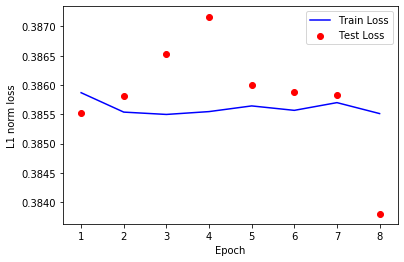

In [135]:
fig = plt.figure()
plt.plot(range(1, n_epochs + 1), train_losses, color='blue')
# TODO: Something seems wrong to me, the test loss shouldn't be below the training loss.
plt.scatter(range(1, n_epochs + 1), test_losses[1:], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('L1 norm loss')

## Inference Example With Trained Network From Test Dataset

In [129]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets, example_debug) = next(examples)

In [130]:
with torch.no_grad():
  output = model(example_data.to(device))
  output = output.cpu()

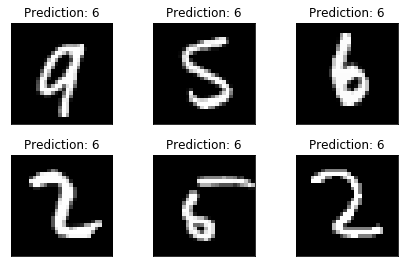

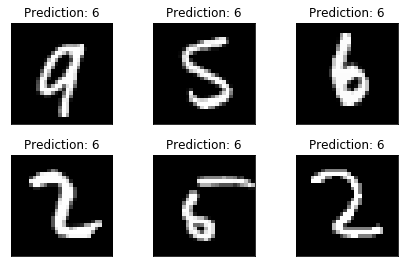

In [131]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  # TODO: Don't we have problems with imshow() changing the brightness?
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continue Training From Saved Checkpoint &amp; Final Training Results

In [132]:
# TODO: Test whether all this old code still works with all the experiment
# changes.

# continued_network = Net()
# continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                                 momentum=momentum)

# network_state_dict = torch.load(model_path)
# continued_network.load_state_dict(network_state_dict)

# optimizer_state_dict = torch.load(optimizer_path)
# continued_optimizer.load_state_dict(optimizer_state_dict)

In [133]:
# def continue_training():
#   for i in range(4, 9):
#     test_counter.append(i*len(train_loader.dataset))
#     train(i)
#     test()

# %time continue_training()

In [134]:
# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')